In [1]:
from pyspark.sql import SparkSession
from pyspark_helper.pyspark_helper import *
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DoubleType, TimestampType
import datetime
from pyspark.sql.window import Window

spark = SparkSession.builder \
    .master("local") \
    .appName("example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

sc = spark.sparkContext

In [2]:
ts_data = [(datetime.datetime(2015, 9, 11, 2, 15),  23000,  None,     12.0,                     'H'),
           (datetime.datetime(2015, 9, 11, 3, 15),  None,   8922.12,  92.9321239132710923132, 'H'),
           (datetime.datetime(2015, 9, 11, 3, 30),  23283,  8231.8,   123.827321323321,       'T'),
           (datetime.datetime(2015, 9, 11, 3, 45),  23000,  3211.019, 72.12,                  None),
           (datetime.datetime(2015, 9, 11, 4, 0),   12732,  6232.15,  None,                   'T'),
           (datetime.datetime(2015, 9, 11, 4, 30),  25038,  None,     83.0,                   'T')
          ]

ts_schema = StructType([ \
    StructField("ts",TimestampType(),True), \
    StructField("integers",IntegerType(),True), \
    StructField("floats",FloatType(),True), \
    StructField("doubles",DoubleType(),True), \
    StructField("category",StringType(),True), 
])    

ts_df = spark.createDataFrame(data=ts_data,schema=ts_schema)
ts_df.show()

+-------------------+--------+--------+----------------+--------+
|                 ts|integers|  floats|         doubles|category|
+-------------------+--------+--------+----------------+--------+
|2015-09-11 02:15:00|   23000|    null|            12.0|       H|
|2015-09-11 03:15:00|    null| 8922.12|92.9321239132711|       H|
|2015-09-11 03:30:00|   23283|  8231.8|123.827321323321|       T|
|2015-09-11 03:45:00|   23000|3211.019|           72.12|    null|
|2015-09-11 04:00:00|   12732| 6232.15|            null|       T|
|2015-09-11 04:30:00|   25038|    null|            83.0|       T|
+-------------------+--------+--------+----------------+--------+



In [3]:
# generate dataframe summary and output to file
df_summary_tofile(ts_df)

In [4]:
# fill the missing time gaps with time step of 15 minutes
ts_df_filled = fill_timegap(spark, ts_df, 'ts', 15*60)
ts_df_filled.show()

+-------------------+--------+--------+----------------+--------+
|                 ts|integers|  floats|         doubles|category|
+-------------------+--------+--------+----------------+--------+
|2015-09-11 02:15:00|   23000|    null|            12.0|       H|
|2015-09-11 02:30:00|    null|    null|            null|    null|
|2015-09-11 02:45:00|    null|    null|            null|    null|
|2015-09-11 03:00:00|    null|    null|            null|    null|
|2015-09-11 03:15:00|    null| 8922.12|92.9321239132711|       H|
|2015-09-11 03:30:00|   23283|  8231.8|123.827321323321|       T|
|2015-09-11 03:45:00|   23000|3211.019|           72.12|    null|
|2015-09-11 04:00:00|   12732| 6232.15|            null|       T|
|2015-09-11 04:15:00|    null|    null|            null|    null|
|2015-09-11 04:30:00|   25038|    null|            83.0|       T|
+-------------------+--------+--------+----------------+--------+



In [5]:
# fill the 'category' column using mode strategy
ts_df_filled_cat = fill_na(ts_df_filled, 'category', fill_with=None, strategy='mode')
ts_df_filled_cat.show()

+-------------------+--------+--------+----------------+--------+
|                 ts|integers|  floats|         doubles|category|
+-------------------+--------+--------+----------------+--------+
|2015-09-11 02:15:00|   23000|    null|            12.0|       H|
|2015-09-11 02:30:00|    null|    null|            null|       T|
|2015-09-11 02:45:00|    null|    null|            null|       T|
|2015-09-11 03:00:00|    null|    null|            null|       T|
|2015-09-11 03:15:00|    null| 8922.12|92.9321239132711|       H|
|2015-09-11 03:30:00|   23283|  8231.8|123.827321323321|       T|
|2015-09-11 03:45:00|   23000|3211.019|           72.12|       T|
|2015-09-11 04:00:00|   12732| 6232.15|            null|       T|
|2015-09-11 04:15:00|    null|    null|            null|       T|
|2015-09-11 04:30:00|   25038|    null|            83.0|       T|
+-------------------+--------+--------+----------------+--------+



In [6]:
# map category into numeric labels
ts_df_filled_cat_mapped = map_categorical_data(ts_df_filled_cat, 'category', 'mapped_category')
ts_df_filled_cat_mapped.show()

+-------------------+--------+--------+----------------+--------+---------------+
|                 ts|integers|  floats|         doubles|category|mapped_category|
+-------------------+--------+--------+----------------+--------+---------------+
|2015-09-11 02:15:00|   23000|    null|            12.0|       H|              1|
|2015-09-11 02:30:00|    null|    null|            null|       T|              0|
|2015-09-11 02:45:00|    null|    null|            null|       T|              0|
|2015-09-11 03:00:00|    null|    null|            null|       T|              0|
|2015-09-11 03:15:00|    null| 8922.12|92.9321239132711|       H|              1|
|2015-09-11 03:30:00|   23283|  8231.8|123.827321323321|       T|              0|
|2015-09-11 03:45:00|   23000|3211.019|           72.12|       T|              0|
|2015-09-11 04:00:00|   12732| 6232.15|            null|       T|              0|
|2015-09-11 04:15:00|    null|    null|            null|       T|              0|
|2015-09-11 04:3

In [7]:
# do iterative imputation for missing values
ts_df_imputed = iterative_imputation(sc, ts_df_filled_cat_mapped, ['ts', 'category'], ['ts'])
ts_df_imputed.show()

+-------------------+--------+--------------+----------------+------------------+---------------+
|                 ts|category|      integers|          floats|           doubles|mapped_category|
+-------------------+--------+--------------+----------------+------------------+---------------+
|2015-09-11 02:15:00|       H|       23000.0|6649.71435546875|              12.0|            1.0|
|2015-09-11 02:30:00|       T|21410.66796875|6649.47216796875|  76.6187973022461|            0.0|
|2015-09-11 02:45:00|       T|21410.66796875|6649.47216796875|  76.6187973022461|            0.0|
|2015-09-11 03:00:00|       T|21410.66796875|6649.47216796875|  76.6187973022461|            0.0|
|2015-09-11 03:15:00|       H|21411.00390625| 8922.1201171875| 92.93212127685547|            1.0|
|2015-09-11 03:30:00|       T|       23283.0| 8231.7998046875|123.82732391357422|            0.0|
|2015-09-11 03:45:00|       T|       23000.0|3211.01904296875| 72.12000274658203|            0.0|
|2015-09-11 04:00:00

In [8]:
from pyspark_helper.pyspark_helper2 import *

one_hot_encoding(ts_df_imputed, 'category', 'mapped_category').show()

+-------------------+--------+--------------+----------------+------------------+---------------+-------------+----+----+
|                 ts|category|      integers|          floats|           doubles|mapped_category| category_vec|ls_T|ls_H|
+-------------------+--------+--------------+----------------+------------------+---------------+-------------+----+----+
|2015-09-11 02:15:00|       H|       23000.0|6649.71435546875|              12.0|            1.0|(2,[1],[1.0])|   0|   1|
|2015-09-11 02:30:00|       T|21410.66796875|6649.47216796875|  76.6187973022461|            0.0|(2,[0],[1.0])|   1|   0|
|2015-09-11 02:45:00|       T|21410.66796875|6649.47216796875|  76.6187973022461|            0.0|(2,[0],[1.0])|   1|   0|
|2015-09-11 03:00:00|       T|21410.66796875|6649.47216796875|  76.6187973022461|            0.0|(2,[0],[1.0])|   1|   0|
|2015-09-11 03:15:00|       H|21411.00390625| 8922.1201171875| 92.93212127685547|            1.0|(2,[1],[1.0])|   0|   1|
|2015-09-11 03:30:00|   

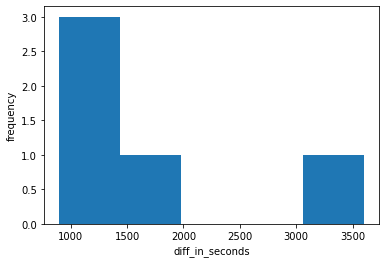

+-------------------+-------------------+---------------+
|                 ts|            ts_next|diff_in_seconds|
+-------------------+-------------------+---------------+
|2015-09-11 02:15:00|2015-09-11 03:15:00|           3600|
|2015-09-11 03:15:00|2015-09-11 03:30:00|            900|
|2015-09-11 03:30:00|2015-09-11 03:45:00|            900|
|2015-09-11 03:45:00|2015-09-11 04:00:00|            900|
|2015-09-11 04:00:00|2015-09-11 04:30:00|           1800|
|2015-09-11 04:30:00|               null|           null|
+-------------------+-------------------+---------------+

+---------------+-----+
|diff_in_seconds|count|
+---------------+-----+
|           3600|    1|
|            900|    3|
|           1800|    1|
|           null|    1|
+---------------+-----+



In [9]:
# identify time gaps in the df
raw, grouped = identify_timegaps(ts_df, 'ts', plot_hist=True, hist_buckets=5)
raw.show()
grouped.show()